# Lintul-Wofost

Quick notebook to see both LINTUL-3 and WOFOST in action for winter wheat

The LINTUL-3 output is taken as reference standard. WOFOST parameters have been "calibrated" to match LINTUL-3 results.

In [1]:
# Install libraries
!rm -fr /content/PCSE-Gym
!git clone -n https://github.com/BigDataWUR/PCSE-Gym.git --depth 1
!cd /content/PCSE-Gym && git checkout HEAD notebooks/nitrogen-winterwheat/lintul-wofost.patch

!pip3 uninstall -y --quiet pcse
!rm -fr /content/pcse && cd /content/ && git clone https://github.com/ajwdewit/pcse.git
!cd /content/pcse && git switch develop_WOFOST_v8_1 && git apply /content/PCSE-Gym/notebooks/nitrogen-winterwheat/lintul-wofost.patch && pip3 install --quiet -e .

import sys
sys.path += ['/content/pcse']

Cloning into 'PCSE-Gym'...
remote: Enumerating objects: 71, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 71 (delta 10), reused 53 (delta 8), pack-reused 0
Unpacking objects: 100% (71/71), 74.76 MiB | 4.67 MiB/s, done.
Updated 1 path from 37f2fd3
Cloning into 'pcse'...
remote: Enumerating objects: 10508, done.
remote: Counting objects: 100% (439/439), done.
remote: Compressing objects: 100% (151/151), done.
remote: Total 10508 (delta 337), reused 324 (delta 288), pack-reused 10069
Receiving objects: 100% (10508/10508), 99.56 MiB | 14.73 MiB/s, done.
Resolving deltas: 100% (4865/4865), done.
Updating files: 100% (789/789), done.
Updating files: 100% (208/208), done.
Branch 'develop_WOFOST_v8_1' set up to track remote branch 'develop_WOFOST_v8_1' from 'origin'.
Switched to a new branch 'develop_WOFOST_v8_1'
/content/PCSE-Gym/notebooks/nitrogen-winterwheat/lintul-wofost.patch:209: trailing whitespace.
** physical soil ch

In [2]:
import pcse
import os
import matplotlib
import matplotlib.pyplot as plt
import yaml
import datetime
import pandas as pd
import numpy as np

def replace_years(agro_management, years):
    if not isinstance(years, list):
        years = [years]

    updated_agro_management = [{k.replace(year=year): v for k, v in agro.items()} for agro, year in zip(agro_management, years)]

    def replace_year_value(d, year):
        for k,v in d.items():
            if isinstance(v, dict):
                replace_year_value(v, year)
            else:
                if isinstance(v, datetime.date):
                    up_dict = {k: v.replace(year=year)}
                    d.update(up_dict)

    for agro, year in zip(updated_agro_management, years):
        replace_year_value(agro, year)
    return updated_agro_management

run LINTUL
run WOFOST


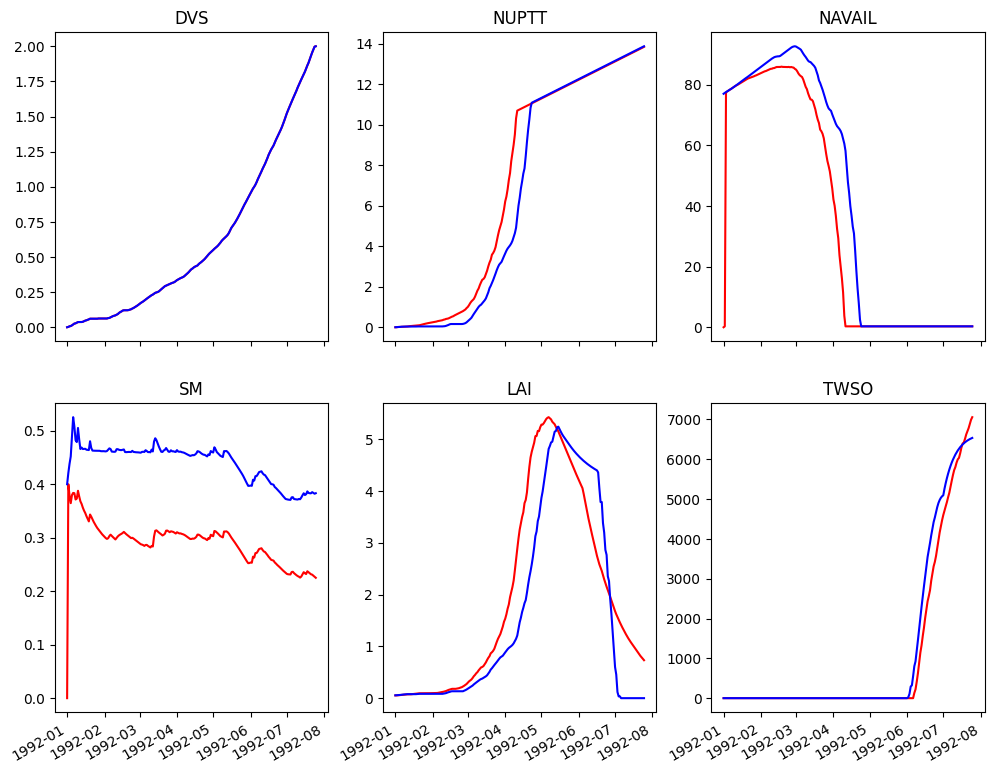

In [3]:
config_dir='/content/pcse/tests/test_data/lintul-wofost'
test_year = 1992
location = (52,5.5)

#######
print("run LINTUL")
weather_data_provider = pcse.db.NASAPowerWeatherDataProvider(*location)
model_config='Lintul3.conf'
agro_config=os.path.join(config_dir,'agromanagement_fertilization.yaml')
crop_params=pcse.fileinput.PCSEFileReader(os.path.join(config_dir,'lintul3_winterwheat.crop'))
site_params=pcse.fileinput.PCSEFileReader(os.path.join(config_dir,'lintul3_springwheat.site'))
soil_params=pcse.fileinput.PCSEFileReader(os.path.join(config_dir,'lintul3_springwheat.soil'))
with open(agro_config, 'r') as f:
    agro_management = yaml.load(f, Loader=yaml.SafeLoader)
    agro_management = replace_years(agro_management, test_year)

parameter_provider = pcse.base.ParameterProvider(cropdata=crop_params, sitedata=site_params, soildata=soil_params)
model = pcse.engine.Engine(parameter_provider, weather_data_provider, agro_management, config=model_config)
model._send_signal(signal=pcse.signals.apply_n, amount=7.7, recovery=1.0) #7.7
model.run_till_terminate()
lintul_results = pd.DataFrame(model.get_output())
lintul_results = lintul_results.set_index("day")

#######
print("run WOFOST")
model_config='Wofost81_NWLP_FD.conf'
agro_config=os.path.join(config_dir, 'wheat_cropcalendar.yaml')
crop_params=pcse.fileinput.YAMLCropDataProvider(config_dir)
site_params=pcse.util.WOFOST80SiteDataProvider(WAV=100, NAVAILI=(77), PAVAILI=50, KAVAILI=250, NSOILBASE_FR=0.003, NSOILBASE=100) #+170.7*0.7
soil_params=pcse.fileinput.CABOFileReader(os.path.join(config_dir,'ec4.CAB'))
with open(agro_config, 'r') as f:
    agro_management = yaml.load(f, Loader=yaml.SafeLoader)
    agro_management = replace_years(agro_management, test_year)

parameter_provider = pcse.base.ParameterProvider(cropdata=crop_params, sitedata=site_params, soildata=soil_params)
model = pcse.engine.Engine(parameter_provider, weather_data_provider, agro_management, config=model_config)
model.run_till_terminate()
wofost_results = pd.DataFrame(model.get_output())
wofost_results = wofost_results.set_index("day")


######
# Name and unit of state variables differ between WOFOST and LINTUL
# Below some mapping

lintul_results["TAGP"] = 10.0*lintul_results['TAGBM']
lintul_results["SM"] = lintul_results['WC']
lintul_results["NAVAIL"] = 10.0*lintul_results['TNSOIL']
lintul_results["TWSO"] = 10.0*lintul_results['WSO']
lintul_results["RFTRA"] = lintul_results['TRANRF']
wofost_results["NUPTT"] = 0.1*np.cumsum(wofost_results["RNuptake"])
wofost_results["TWSO"] = wofost_results["WSO"]
lintul_results["RFNPK"] = lintul_results['NRF']

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12,10))
for var, ax in zip(["DVS", "NUPTT", "NAVAIL", "SM", "LAI", "TWSO"], axes.flatten()):
    ax.plot_date(lintul_results.index, lintul_results[var], 'r-')
    ax.plot_date(wofost_results.index, wofost_results[var], 'b-')
    ax.set_title(var)
fig.autofmt_xdate()